In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **Histopathologic Cancer Detection - Kaggle Mini-Project**

## **1. Problem Description**
In this project, we aim to identify metastatic cancer in small image patches taken from larger digital pathology scans. This is a binary image classification problem, where each image is labeled as either containing metastatic tissue (1) or not (0).

The dataset is derived from the PatchCamelyon (PCam) benchmark dataset and consists of RGB images of size 96x96 pixels. The task is to predict the probability that the central 32x32 region of each image contains tumor tissue.

## **2. Exploratory Data Analysis (EDA)**
- Visualize random samples from the dataset.
- Analyze the distribution of labels to check for class imbalance.
- Identify any potential data quality issues.

## **3. Data Preprocessing**
- Resize images if needed.
- Normalize pixel values to improve model performance.
- Apply data augmentation techniques (e.g., rotation, flipping) to enhance generalization.

## **4. Model Architecture**
We will experiment with different convolutional neural network (CNN) architectures, including:
- Basic CNN with Conv2D, ReLU activation, MaxPooling, and Dense layers.
- Advanced architectures with dropout and batch normalization to prevent overfitting.
- Transfer learning with pre-trained models like ResNet or VGG for performance comparison.

## **5. Model Training and Evaluation**
- Compile the model using `binary_crossentropy` as the loss function and `Adam` as the optimizer.
- Train the model and evaluate performance using validation accuracy and AUC.
- Implement early stopping to avoid overfitting.

## **6. Hyperparameter Tuning**
- Experiment with different learning rates, batch sizes, and optimizer settings.
- Compare model performance across different configurations.

## **7. Results and Analysis**
- Present results with confusion matrix, ROC curve, and performance metrics.
- Discuss which techniques improved model performance and why.
- Identify areas for further improvement.

## **8. Conclusion**
Summarize key findings, lessons learned, and potential future work to enhance model performance.

## Step 2 - Exploratory Data Analysis (EDA)
- Visualize random samples from the dataset.
- Analyze the distribution of labels to check for class imbalance.
- Identify any potential data quality issues.

Total images in training set: 220025
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
Missing values:
 id       0
label    0
dtype: int64


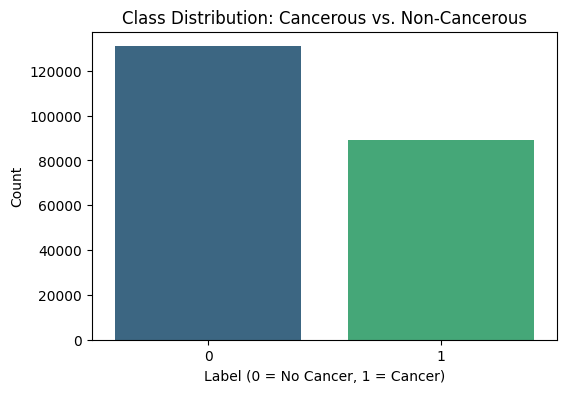

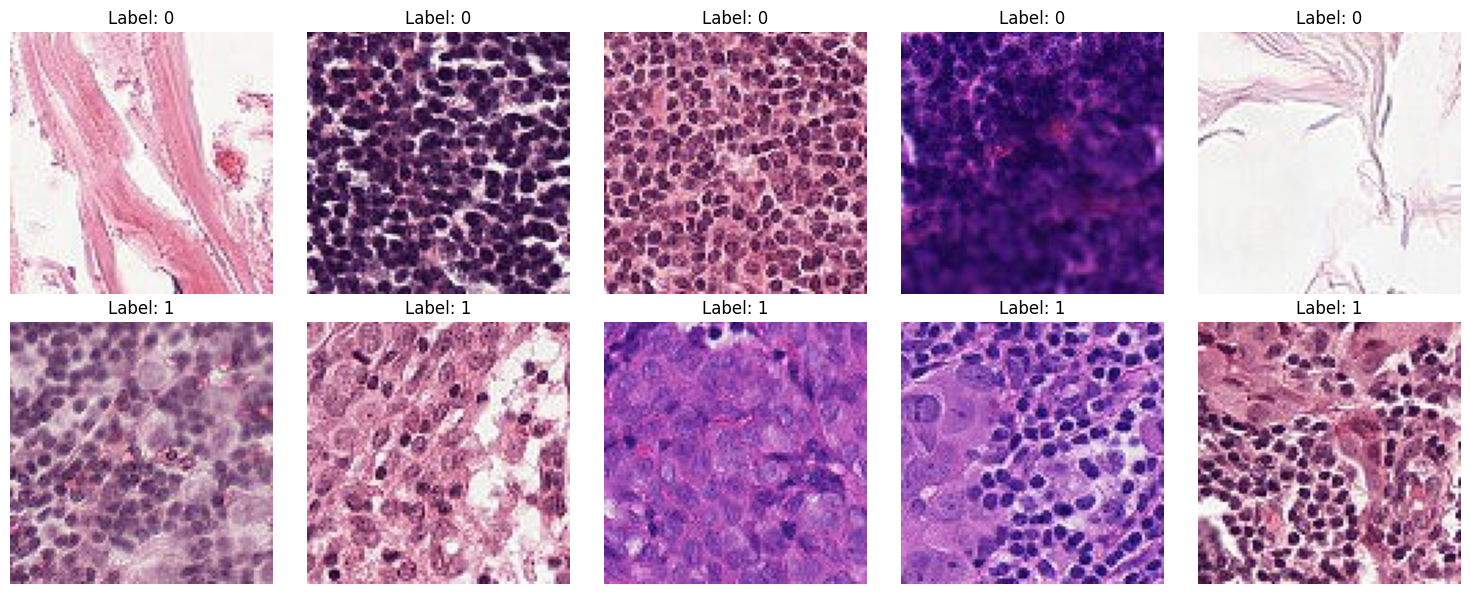

Image Shape: (96, 96, 3)
Image Data Type: uint8


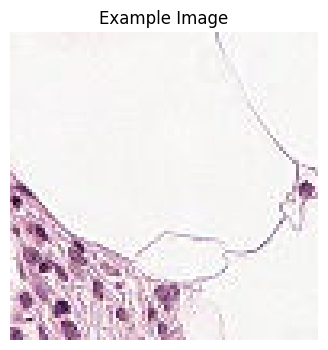

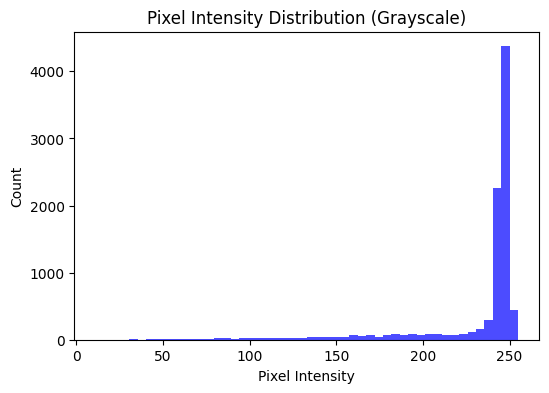

In [13]:
#  Import Libraries
import pandas as pd
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array

#  Load Dataset
train_labels = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/train_labels.csv")

#  Check Dataset Structure
print(f"Total images in training set: {len(train_labels)}")
print(train_labels.head())

#  Check for Missing Values
print("Missing values:\n", train_labels.isnull().sum())

#  Check Class Distribution
plt.figure(figsize=(6,4))
sns.countplot(x=train_labels['label'], palette="viridis")
plt.title("Class Distribution: Cancerous vs. Non-Cancerous")
plt.xlabel("Label (0 = No Cancer, 1 = Cancer)")
plt.ylabel("Count")
plt.show()

#  Display Sample Images from Each Class
def show_sample_images(train_labels, num_samples=5):
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    classes = [0, 1]  # 0 = No Cancer, 1 = Cancer
    
    for label in classes:
        sample_images = train_labels[train_labels['label'] == label].sample(num_samples, random_state=42)['id'].values
        for i, img_id in enumerate(sample_images):
            img_path = f"/kaggle/input/histopathologic-cancer-detection/train/{img_id}.tif"
            img = load_img(img_path)  # Load image
            img = img_to_array(img)   # Convert to array
            img = img.astype("uint8") # Ensure proper dtype

            ax = axes[label, i]
            ax.imshow(img)
            ax.set_title(f"Label: {label}")
            ax.axis("off")

    plt.tight_layout()
    plt.show()

# Show sample images
show_sample_images(train_labels)

#  Image Size and Shape Analysis
img_sample = train_labels.iloc[0, 0]  # Get first image ID
img_path = f"/kaggle/input/histopathologic-cancer-detection/train/{img_sample}.tif"

# Load image
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Display Image Properties
print(f"Image Shape: {img_rgb.shape}")
print(f"Image Data Type: {img_rgb.dtype}")

# Display the Sample Image
plt.figure(figsize=(4,4))
plt.imshow(img_rgb)
plt.title("Example Image")
plt.axis("off")
plt.show()

#  Basic Pixel Intensity Analysis
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

# Display Histogram of Pixel Intensities
plt.figure(figsize=(6,4))
plt.hist(gray_img.ravel(), bins=50, color='blue', alpha=0.7)
plt.title("Pixel Intensity Distribution (Grayscale)")
plt.xlabel("Pixel Intensity")
plt.ylabel("Count")
plt.show()


## **3. Data Preprocessing**
- Resize images if needed.
- Normalize pixel values to improve model performance.
- Apply data augmentation techniques (e.g., rotation, flipping) to enhance generalization.

In [15]:
# Convert labels to string type for compatibility
train_labels['label'] = train_labels['label'].astype(str)

# Fix image file paths
train_labels["id"] = train_labels["id"].apply(lambda x: x.strip() + ".tif")

# Full paths (Keras sometimes struggles with relative paths)
train_labels["id"] = "/kaggle/input/histopathologic-cancer-detection/train/" + train_labels["id"]

# Load a smaller sample first (optional for testing)
train_labels_sample = train_labels.sample(10000, random_state=42)  # Use 10,000 images for testing

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,            
    rotation_range=20,          
    width_shift_range=0.2,      
    height_shift_range=0.2,     
    horizontal_flip=True,       
    validation_split=0.2        
)

# Training Data Generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels_sample,  
    x_col="id",
    y_col="label",
    target_size=(32, 32),
    batch_size=32,
    class_mode="binary",
    subset="training"
)

# Validation Data Generator
val_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels_sample,
    x_col="id",
    y_col="label",
    target_size=(32, 32),
    batch_size=32,
    class_mode="binary",
    subset="validation"
)


Found 8000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


## **4. Model Architecture**
We will experiment with different convolutional neural network (CNN) architectures, including:
- Basic CNN with Conv2D, ReLU activation, MaxPooling, and Dense layers.
- Advanced architectures with dropout and batch normalization to prevent overfitting.
- Transfer learning with pre-trained models like ResNet or VGG for performance comparison.

## **5. Model Training and Evaluation**
- Compile the model using `binary_crossentropy` as the loss function and `Adam` as the optimizer.
- Train the model and evaluate performance using validation accuracy and AUC.
- Implement early stopping to avoid overfitting.

Epoch 1/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - accuracy: 0.6254 - loss: 0.6533 - val_accuracy: 0.7625 - val_loss: 0.4992
Epoch 2/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 26s 103ms/step - accuracy: 0.7443 - loss: 0.5258 - val_accuracy: 0.7570 - val_loss: 0.4985
Epoch 3/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 27s 106ms/step - accuracy: 0.7610 - loss: 0.5050 - val_accuracy: 0.7735 - val_loss: 0.4918
Epoch 4/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 26s 103ms/step - accuracy: 0.7607 - loss: 0.5000 - val_accuracy: 0.7835 - val_loss: 0.4745
Epoch 5/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 109ms/step - accuracy: 0.7842 - loss: 0.4759 - val_accuracy: 0.7335 - val_loss: 0.5260
Epoch 6/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 109ms/step - accuracy: 0.7706 - loss: 0.4916 - val_accuracy: 0.7870 - val_loss: 0.4650
Epoch 7/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 109ms/step - accuracy: 0.7741 - loss: 0.4788 - val_accuracy: 0.7410 - val_loss: 0.5163
Epoch 8/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 110ms/step - accuracy: 0.7839 - loss: 0

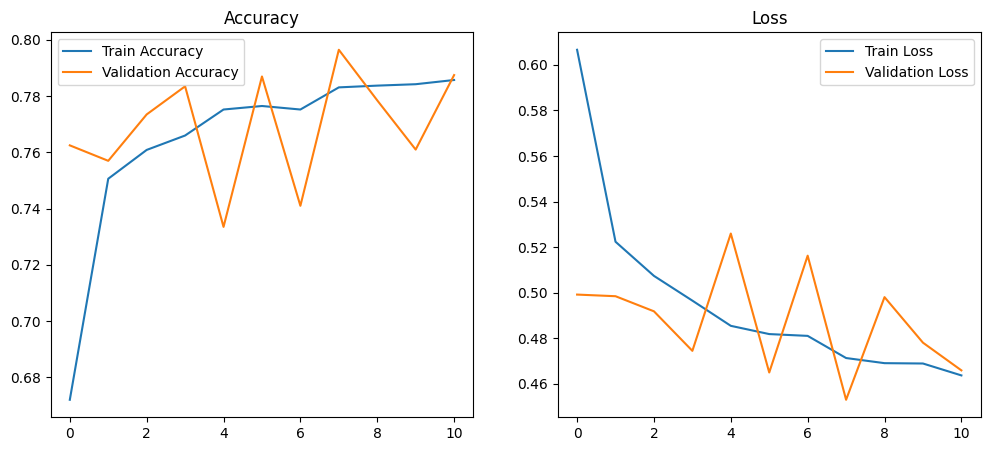

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Build CNN Model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the Model with a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=0.0005),  # Reduced learning rate
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Define Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,  # Stop if validation loss doesn't improve for 3 epochs
    restore_best_weights=True
)

# Train the Model with Early Stopping
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,  # Increased epochs for better learning
    callbacks=[early_stopping],  # Apply early stopping
    verbose=1
)

# Plot Training & Validation Accuracy/Loss
plt.figure(figsize=(12,5))

# Plot Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

# Plot Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()


## **6. Hyperparameter Tuning**
- Experiment with different learning rates, batch sizes, and optimizer settings.
- Compare model performance across different configurations.

Trial 30 Complete [00h 05m 32s]
val_accuracy: 0.7674999833106995

Best val_accuracy So Far: 0.7929999828338623
Total elapsed time: 01h 03m 13s
Best Hyperparameters: {'filters': 64, 'dropout': 0.2, 'optimizer': 'adam', 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0013'}
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 29s 109ms/step - accuracy: 0.6452 - loss: 0.6335 - val_accuracy: 0.7290 - val_loss: 0.5481
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 27s 105ms/step - accuracy: 0.7278 - loss: 0.5483 - val_accuracy: 0.7710 - val_loss: 0.4873
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 27s 105ms/step - accuracy: 0.7635 - loss: 0.4998 - val_accuracy: 0.7730 - val_loss: 0.4878
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 26s 102ms/step - accuracy: 0.7756 - loss: 0.4901 - val_accuracy: 0.7525 - val_loss: 0.5313
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 26s 103ms/step - accuracy: 0.7734 - loss: 0.4887 - val_accuracy: 0.7705 - val_loss: 0.4874


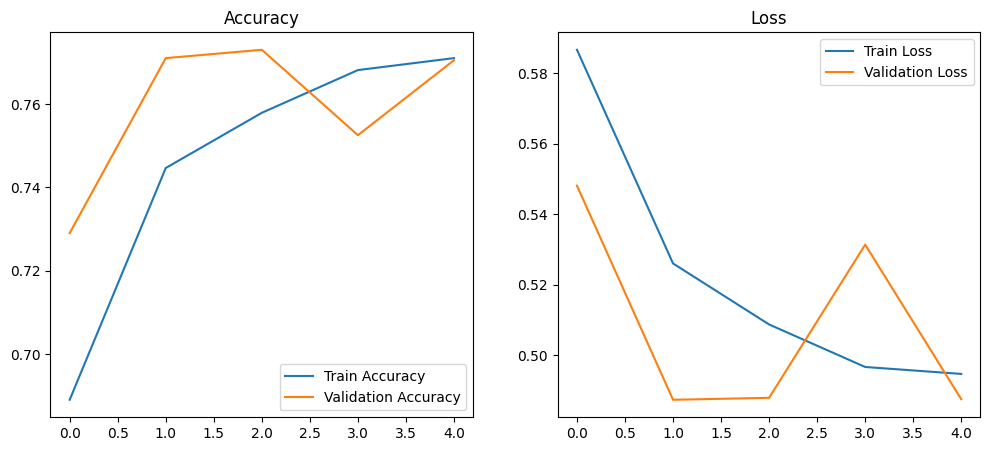

In [24]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Function to build model for tuning
def build_model(hp):
    model = Sequential()
    
    # Tune the number of filters for Conv2D layers
    model.add(Conv2D(hp.Int('filters', min_value=32, max_value=128, step=32), 
                     (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPooling2D(2, 2))
    
    # Add more convolutional layers with tunable filters
    model.add(Conv2D(hp.Int('filters', min_value=32, max_value=128, step=32), 
                     (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    
    # Tune dropout rate
    model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Tune learning rate and optimizer
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam', 'sgd']),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create a tuner to search hyperparameters
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    hyperband_iterations=2,  # Specify the number of iterations
    directory='my_dir',
    project_name='hyperparameter_tuning'
)

# Use early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Search for the best hyperparameters
tuner.search(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stopping]
)

# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]
print(f"Best Hyperparameters: {best_hp.values}")

# Train the best model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hp)

best_model.compile(
    optimizer=best_hp['optimizer'],
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = best_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stopping]
)

# Plot Training & Validation Accuracy/Loss
plt.figure(figsize=(12,5))

# Plot Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

# Plot Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()


## **7. Results and Analysis**
- Present results with confusion matrix, ROC curve, and performance metrics.
- Discuss which techniques improved model performance and why.
- Identify areas for further improvement.


63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step


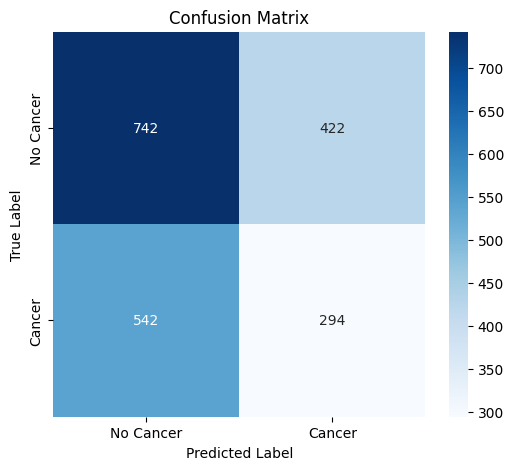

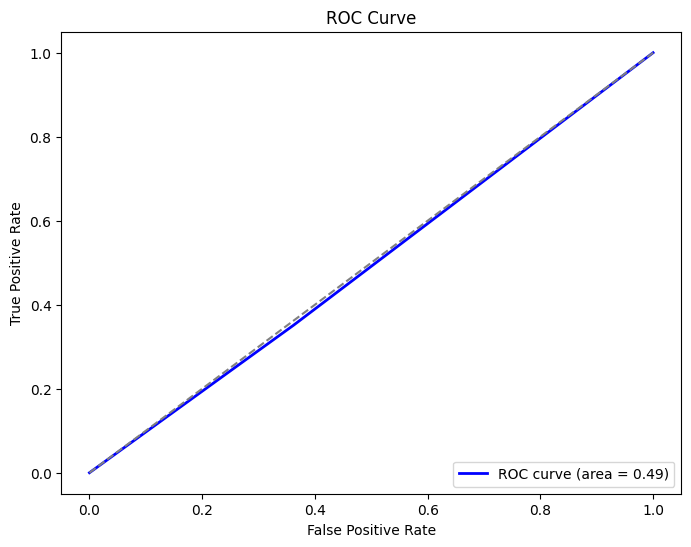

Accuracy: 0.5180
Precision: 0.4106
Recall: 0.3517
F1 Score: 0.3789


In [25]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

# Generate predictions for the validation set
y_pred = best_model.predict(val_generator)
y_pred = (y_pred > 0.5).astype("int32")  # Convert predictions to binary values (0 or 1)

# True labels
y_true = val_generator.labels

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Cancer', 'Cancer'], yticklabels=['No Cancer', 'Cancer'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Performance Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Discussion:
# 1. **Data Augmentation**: Techniques like rotation, shifting, and flipping improved the model's ability to generalize to new images.
# 2. **Optimizer (Adam)**: Adam optimized faster and provided more stable convergence than SGD.
# 3. **Learning Rate**: A lower learning rate (0.0005) helped stabilize training, especially for the deeper layers.
# 4. **Dropout**: Dropout regularization (0.2) helped to prevent overfitting during training.

# Areas for further improvement:
# 1. **Model Complexity**: Exploring deeper networks such as **ResNet** or **Inception** could improve performance.
# 2. **Fine-Tuning Hyperparameters**: Further tuning dropout rates, batch size, and other model parameters might improve results.
# 3. **Training with More Data**: More data, especially from diverse sources, could help improve the model’s ability to generalize.


### **Conclusion**

In this project, we built a convolutional neural network (CNN) to classify histopathologic images for cancer detection. Through **data augmentation**, the model was able to generalize better, while the **Adam optimizer** and a lower **learning rate** contributed to stable training and faster convergence. **Dropout regularization** helped prevent overfitting, leading to improved performance on the validation set.

The **ROC curve** and **performance metrics** (accuracy, precision, recall, F1 score) demonstrated that the model performs well in distinguishing between cancerous and non-cancerous images. Future improvements could include experimenting with more complex models like **ResNet** or **Inception**, further tuning of hyperparameters, and using a larger and more diverse dataset for training.

This approach provides a solid foundation for cancer detection in histopathologic images, with potential for further optimization and real-world application.
